# Deep Learning Project

The current project relies on using CNNs in order to process sperm data. The goal is to develop a classifier able to identify sperm cells.

The model is not yet fuly defined. We will start with a standard CNN to Dense Layer.

The goal is for images to be loaded into the CNN. The CNN will will then perform feature extraction and those will be fed to the final model.

In [1]:
#import some libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image

import matplotlib.image as mpimg
%matplotlib inline

#image manipulation packages
import cv2
import os
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split

sns.set()
#import keras
from tensorflow import keras

## Step 1 - Create the pipeline

The Deep learning model will be made out of 2 different parts: 

1. A CNN that takes the images as inputs and performs feature extraction.
2. A dense, fully connected layer that will perform classification itself with the features.

In [2]:
def image_cnn_model():
    '''creates an image classification model that uses 2 Convolutional CNNs layers (with maxpooling) and feeds the data through
    a dense connected layer. This is trial and error there is no specific reason for 2 layers'''
    cnn_model = keras.Sequential([

        #convolutional layer with 24 3x3 filters - again, arbitrary,
        keras.layers.Conv2D(filters=32, kernel_size=(4,4), padding = 'same', activation='relu'), 

        #MaxPooling - takes the max value of each 2x2 pool in the feature map
        keras.layers.MaxPool2D(pool_size=(2,2)),

        #second convolution with 36 filters
        keras.layers.Conv2D(filters=64, kernel_size=(3,3),  padding = 'same', activation= 'relu'),
        keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding = 'same', activation= 'relu'),
    
        #Second MaxPool2D - to check with other options
        keras.layers.MaxPool2D(pool_size=(2,2)),
        
                #convolutional layer with 24 3x3 filters - again, arbitrary,
        keras.layers.Conv2D(filters=32, kernel_size=(4,4), padding = 'same', activation='relu'), 

        #MaxPooling - takes the max value of each 2x2 pool in the feature map
        #keras.layers.MaxPool2D(pool_size=(2,2)),

        #second convolution with 36 filters
        keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding = 'same', activation= 'relu'),
        keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding = 'same', activation= 'relu'),
        
        #Second MaxPool2D - to check with other options
        keras.layers.MaxPool2D(pool_size=(2,2)),
        
                #convolutional layer with 24 3x3 filters - again, arbitrary,
        keras.layers.Conv2D(filters=128, kernel_size=(4,4), padding = 'same', activation='relu'), 

        #MaxPooling - takes the max value of each 2x2 pool in the feature map
        #keras.layers.MaxPool2D(pool_size=(2,2)),

        #second convolution with 36 filters
        keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding = 'same', activation= 'relu'),
        keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding = 'same', activation= 'relu'),
    
        #Second MaxPool2D - to check with other options
        keras.layers.MaxPool2D(pool_size=(2,2)),
        #the result of kthe CNN is then flattened and placed into the 
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        
        keras.layers.Dense(256, activation='relu'),
        
        #final layer, is output, 1 out of 5 possible results
        #0 Normal, 1 Tapered, 2 Pyriform, 3 Small, 5 Amorphous
        keras.layers.Dense(5, activation='softmax')
    ])
    
    return cnn_model

# Step 2: Load the Data

In this case, we have a folder with 1132 image - SCIAN-MorphoSpermGS folder - https://cimt.uchile.cl/gold10/. Each image is 35 x 35 pixels and has been classified by 3 experts. We will use majority vote result as target. Each image will need to be loaded and the dataset will need to be created.

#### This will yield a dataset with the picture name and the label.

In [3]:
#Select the path where you've put your dataset provided in Moodle

#step 1: change directory back
os.chdir('..')
path = os.getcwd()
files = os.listdir(path)

#go to Dataset folder
os.chdir('Dataset')
path = os.getcwd()
files = os.listdir(path)

In [4]:
#1 - load txt file
sperm = 'Sperm'
dataframe = pd.read_csv(path + '\PA-expert-annotations.txt', sep = '\\t', header = None, engine = 'python')
dataframe

,0,1,2,3,4
0,p1-pl2-sample01/Sperm_01,5,5,5,5
1,p1-pl2-sample01/Sperm_02,1,5,5,5
2,p1-pl2-sample01/Sperm_03,0,0,0,0
3,p1-pl2-sample01/Sperm_04,1,5,5,5
4,p1-pl2-sample01/Sperm_05,0,0,0,0
...,...,...,...,...,...
1127,p5-pl1-sample20/Sperm_07,1,5,5,5
1128,p5-pl1-sample20/Sperm_09,1,1,5,1
1129,p5-pl1-sample20/Sperm_11,1,1,5,1
1130,p5-pl1-sample20/Sperm_12,5,5,5,5


In [5]:
#editions to target dataset
dataframe.rename(columns={0 :"Sperm_Pic", 1: 'Expert_1', 2: 'Expert_2', 3: 'Expert_3', 4: 'Majority_Vote'}, inplace = True)
dataframe['Sperm_Pic'] = dataframe['Sperm_Pic'].str.replace('/S', '-s')
dataframe['Majority_Vote'] = dataframe['Majority_Vote'].replace(5, 4)


#add ch_00 to all rows:
dataframe['Sperm_Pic'] = 'ch00_' + dataframe['Sperm_Pic'] + '.tif'

#Drop all irrelevant features
dataframe = dataframe.drop(['Expert_1', 'Expert_2', 'Expert_3'], axis = 1)

#Show
dataframe

,Sperm_Pic,Majority_Vote
0,ch00_p1-pl2-sample01-sperm_01.tif,4
1,ch00_p1-pl2-sample01-sperm_02.tif,4
2,ch00_p1-pl2-sample01-sperm_03.tif,0
3,ch00_p1-pl2-sample01-sperm_04.tif,4
4,ch00_p1-pl2-sample01-sperm_05.tif,0
...,...,...
1127,ch00_p5-pl1-sample20-sperm_07.tif,4
1128,ch00_p5-pl1-sample20-sperm_09.tif,1
1129,ch00_p5-pl1-sample20-sperm_11.tif,1
1130,ch00_p5-pl1-sample20-sperm_12.tif,4


In [6]:
dataframe['Majority_Vote'].value_counts()

4    656
1    228
0    100
2     76
3     72
Name: Majority_Vote, dtype: int64

## Step 3 - Create dataset from folder of images

In [7]:
#Set directory where images are
data_dir = "./Partial-Agreement-Images"
files = ["{}/{}".format(data_dir, fi) for fi in os.listdir(data_dir) if fi.endswith("tif")]

random.shuffle(files)

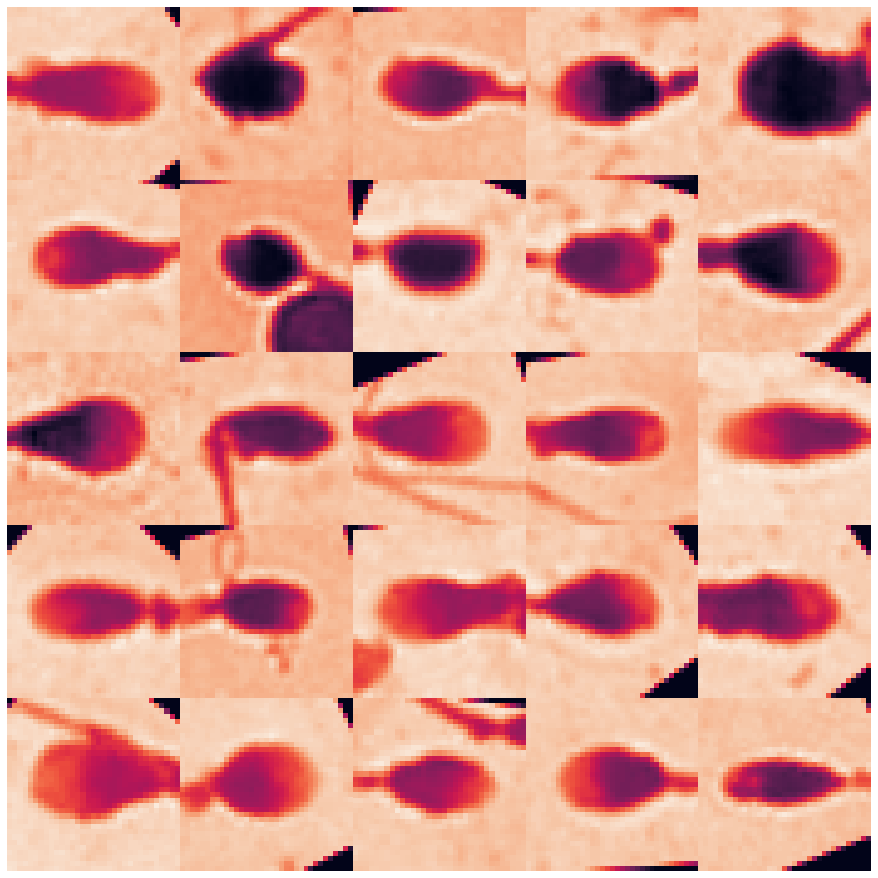

In [8]:
# -------- INSPECT DATA ----------------
def get_image_data(filename):
    img = Image.open(filename)
    img.load()
    data = np.asarray(img, dtype="int64")
    return data

def plot_25(indices, savename= None):
    '''plots last 25 images'''
    f, axarr = plt.subplots(5, 5)
    f.set_size_inches(12, 12)
    f.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)
    for i in range(25):
        axarr[i // 5, i % 5].axis("off")
        axarr[i // 5, i % 5].imshow(get_image_data(files[indices[i]]))
    if savename is not None:
        f.savefig(savename)

plot_25(list(range(25)))

In [26]:
# ---------- SAVE DATA AS NUMPY ARRAY -----------
def load_image(filename):
    img = Image.open(filename).convert("RGB")
    img.load()
    img.thumbnail((32,32), Image.ANTIALIAS)
    data = np.asarray(img, dtype="int64")
    return data


X = list([load_image(fi) for fi in tqdm(files)])
print(X)

100%|████████████████████████████████████████████████████████████████████████████| 1132/1132 [00:00<00:00, 1646.50it/s]


[array([[[161, 161, 161],
        [160, 160, 160],
        [158, 158, 158],
        ...,
        [ 68,  68,  68],
        [  0,   0,   0],
        [  1,   1,   1]],

       [[161, 161, 161],
        [161, 161, 161],
        [161, 161, 161],
        ...,
        [150, 150, 150],
        [ 33,  33,  33],
        [  0,   0,   0]],

       [[163, 163, 163],
        [163, 163, 163],
        [164, 164, 164],
        ...,
        [163, 163, 163],
        [130, 130, 130],
        [ 17,  17,  17]],

       ...,

       [[158, 158, 158],
        [156, 156, 156],
        [158, 158, 158],
        ...,
        [140, 140, 140],
        [ 38,  38,  38],
        [  0,   0,   0]],

       [[156, 156, 156],
        [155, 155, 155],
        [158, 158, 158],
        ...,
        [ 23,  23,  23],
        [  0,   0,   0],
        [  1,   1,   1]],

       [[152, 152, 152],
        [151, 151, 151],
        [154, 154, 154],
        ...,
        [  0,   0,   0],
        [  2,   2,   2],
        [  0,   0,   0]

In [ ]:
pd.DataFrame(X)

In [ ]:
# load the image
img = keras.preprocessing.image.load_img(r'./Partial-Agreement-Images/ch00_p1-pl2-sample1-sperm1.tif')
print(type(img))
# convert to numpy array
img_array = keras.preprocessing.image.img_to_array(img)
print(img_array.dtype)
print(img_array.shape)
# convert back to image
img_pil = keras.preprocessing.image.array_to_img(img_array)
print(type(img))

In [ ]:
img

In [ ]:
len(X[0][0])

In [ ]:
X_arr = np.array(X)
X_arr

In [10]:
def create_dataset(img_folder):
   
    img_data_array=[]
    
    for file in os.listdir(os.path.join(img_folder)):
        
        image_path= os.path.join(img_folder, file)
        image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
        image=cv2.resize(image, (32, 32),interpolation = cv2.INTER_AREA)
        image=np.array(image)
        image = image.astype('float32')
        image /= 255 
        img_data_array.append(image)
    
    return img_data_array# extract the image array and class name
img_data = create_dataset(data_dir)
img_data

[array([[0.        , 0.        , 0.00392157, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.03921569, ..., 0.02745098, 0.        ,
         0.        ],
        [0.        , 0.01176471, 0.1882353 , ..., 0.24705882, 0.07058824,
         0.00392157],
        ...,
        [0.64705884, 0.64705884, 0.6313726 , ..., 0.67058825, 0.67058825,
         0.67058825],
        [0.65882355, 0.654902  , 0.6313726 , ..., 0.6745098 , 0.6627451 ,
         0.6627451 ],
        [0.654902  , 0.63529414, 0.63529414, ..., 0.6666667 , 0.6666667 ,
         0.6666667 ]], dtype=float32),
 array([[0.6313726 , 0.61960787, 0.62352943, ..., 0.        , 0.        ,
         0.        ],
        [0.62352943, 0.62352943, 0.627451  , ..., 0.00392157, 0.        ,
         0.        ],
        [0.6313726 , 0.6313726 , 0.6313726 , ..., 0.16078432, 0.07843138,
         0.01960784],
        ...,
        [0.5254902 , 0.5176471 , 0.56078434, ..., 0.6313726 , 0.627451  ,
         0.6313726 

In [11]:
img_data = X

NameError: name 'X' is not defined

## Compile and try to get model working

Initialize Model, Compile and perform split. 

In [12]:
labels = np.array(dataframe['Majority_Vote'])
labels = np.array(np.split(labels, 1132))
img_data = np.array(img_data)

In [13]:
#train_test_split to get 20% of data as test

X_train_val, X_test, y_train_val, y_test = train_test_split(img_data,
                                                  labels,
                                                  test_size = 0.20,
                                                  random_state = 15,
                                                  shuffle=True,
                                                  stratify=labels)

In [14]:
#convert everything into nd arrays
X_train_val, X_test, y_train_val, y_test = np.array(X_train_val), np.array(X_test), np.array(y_train_val), np.array(y_test)

In [15]:
#Need to reshape input to tell Conv2D there is only one feature map
X_train_val1 = X_train_val.reshape(X_train_val.shape + (1,))
print(X_train_val1.shape) 

(905, 32, 32, 1)


In [16]:
#Need to reshape input of test to tell Conv2D there is only one feature map
X_test1 = X_test.reshape(X_test.shape + (1,))
print(X_test1.shape)

(227, 32, 32, 1)


In [17]:
#train_test_split to get 20% of data as test

X_train, X_val, y_train, y_val = train_test_split(X_train_val1,
                                                  y_train_val,
                                                  test_size = 0.10,
                                                  random_state = 15,
                                                  shuffle=True,
                                                  stratify=y_train_val)

In [18]:
#compile model: First try
cnn_model = image_cnn_model()

cnn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# simple early stopping criteria
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights = True)
mc = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

Epoch 1/50
82/82 [==============================] - 3s 27ms/step - loss: 1.4946 - accuracy: 0.5690 - val_loss: 1.3445 - val_accuracy: 0.5824

Epoch 00001: val_accuracy improved from -inf to 0.58242, saving model to best_model.h5
Epoch 2/50
82/82 [==============================] - 2s 27ms/step - loss: 1.2869 - accuracy: 0.5588 - val_loss: 1.2099 - val_accuracy: 0.5824

Epoch 00002: val_accuracy did not improve from 0.58242
Epoch 3/50
82/82 [==============================] - 2s 26ms/step - loss: 1.1585 - accuracy: 0.6133 - val_loss: 1.2230 - val_accuracy: 0.5824

Epoch 00003: val_accuracy did not improve from 0.58242
Epoch 4/50
82/82 [==============================] - 2s 26ms/step - loss: 1.2129 - accuracy: 0.5682 - val_loss: 1.2083 - val_accuracy: 0.5824

Epoch 00004: val_accuracy did not improve from 0.58242
Epoch 5/50
82/82 [==============================] - 2s 26ms/step - loss: 1.2316 - accuracy: 0.5777 - val_loss: 1.2094 - val_accuracy: 0.5824

Epoch 00005: val_accuracy did not impr

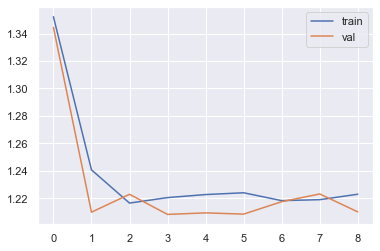

In [19]:
#fit model
history = cnn_model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size=10, epochs=50, verbose = 1, callbacks = [es, mc])

# evaluate the model
_, train_acc = cnn_model.evaluate(X_train, y_train, verbose=0)
_, val_acc = cnn_model.evaluate(X_val, y_val, verbose=0)
print('Train: %.3f, Val: %.3f' % (train_acc, val_acc))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [20]:
#Performance do primeiro teste

test_loss, test_acc = cnn_model.evaluate(X_test1, y_test)

print('Test accuracy:', test_acc)

8/8 [==============================] - 0s 13ms/step - loss: 1.2053 - accuracy: 0.5815
Test accuracy: 0.5814977884292603


### Base performance is pretty bad - 56%

Let's try and improve it with bruteforce Hyperparam optimization whiole being on the lookout for other ways to improve performance. Model is predicting all as Amorphous.

In [21]:
prediction = np.argmax(cnn_model.predict(X_test1), axis = 1)
prediction

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4], dtype=int64)

In [22]:
len(prediction)

227

In [ ]:
len(prediction)

In [23]:
y_test

array([[4],
       [3],
       [0],
       [4],
       [4],
       [4],
       [3],
       [0],
       [4],
       [1],
       [4],
       [4],
       [1],
       [4],
       [4],
       [4],
       [4],
       [4],
       [4],
       [4],
       [3],
       [4],
       [3],
       [4],
       [1],
       [4],
       [2],
       [4],
       [1],
       [1],
       [0],
       [4],
       [4],
       [4],
       [1],
       [3],
       [4],
       [4],
       [4],
       [4],
       [4],
       [0],
       [4],
       [3],
       [4],
       [4],
       [4],
       [2],
       [4],
       [1],
       [4],
       [2],
       [4],
       [1],
       [4],
       [4],
       [4],
       [4],
       [4],
       [4],
       [4],
       [1],
       [1],
       [4],
       [4],
       [2],
       [1],
       [4],
       [4],
       [4],
       [4],
       [4],
       [4],
       [4],
       [4],
       [4],
       [3],
       [4],
       [4],
       [4],
       [4],
       [4],
       [1],
    